In [1]:
import argparse
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import  mean_absolute_error
import matplotlib.pyplot as plt
import pickle
from scipy.stats import ttest_rel

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.02

project_dir = Path('/Users/jdafflon/Code/bblocks-phenotypes/')
#project_dir = Path('/home/jdafflon/bblocks-phenotypes/')

figs_dir = project_dir / 'figs'

# Create output dir 
output_dir = figs_dir / 'preprint_figs'
output_dir.mkdir(exist_ok=True, parents=True)

In [3]:
# load the data
def load_data_reconstruction(dataset, file_dir, y_val):
    # load the list of targets
    if dataset == 'PNC':
        #folder_name = f"regress_covariates_predictions-pnc-latent_targets_svd-zscore_y_val_{y_val}_column-005_component"
        folder_name = f"regress_covariates_predictions-{dataset.lower()}-latent_targets_svd-zscore_y_val_{y_val}_column-039_component"
    elif dataset == 'HCP':
        folder_name = f"regress_covariates_predictions-{dataset.lower()}-latent_targets_svd-zscore_y_val_{y_val}_column-083_component"
    metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)

    dict_corr_mean = {}
    dict_corr_std = {}
    dict_r2_mean = {}
    dict_r2_std = {}
    for i_recon, n_recons in enumerate(recons):
        experiment_name = f"regress_covariates_predictions-{dataset.lower()}-latent_targets_svd-zscore_y_val_{y_val}_column-{n_recons:03d}_component"
        experiment_path = file_dir / experiment_name

        with open(experiment_path / 'metrics.pickle', 'rb') as handle:
            metrics_dic = pickle.load(handle)
        sorted_targets = metrics['sorted_targets']
        res = np.load(experiment_path / 'reconstructed_predictions.npz',
                allow_pickle=True)
        corr_data = np.array(metrics_dic['Correlation'])
        r2_data = np.array(metrics_dic['R2'])

        # save the results
        dict_corr_mean[f'mean_{n_recons}'] = np.mean(corr_data, axis=0)
        dict_corr_std[f'std_{n_recons}'] = np.std(corr_data, axis=0)
        dict_r2_mean[f'mean_{n_recons}'] = np.mean(r2_data, axis=0)
        dict_r2_std[f'std_{n_recons}'] = np.std(r2_data, axis=0)

    df_corr_mean = pd.DataFrame(dict_corr_mean)
    df_r2_mean = pd.DataFrame(dict_r2_mean)
    df_corr_std = pd.DataFrame(dict_corr_std)
    df_r2_std = pd.DataFrame(dict_r2_std)

   # reorder the dataframe to be in the same order as the prediction for all
   # targets. The first metric should be the one that we can predict best
    df_corr_mean = df_corr_mean.reindex(metrics['arg_sort'])
    df_corr_std = df_corr_std.reindex(metrics['arg_sort'])
    df_r2_mean = df_r2_mean.reindex(metrics['arg_sort'])
    df_r2_std = df_r2_std.reindex(metrics['arg_sort'])

    return df_corr_mean, df_corr_std, df_r2_mean, df_r2_std, sorted_targets

# HCP plot (correlation)

In [4]:
dataset = 'HCP'
y_val = 'orig'
file_dir = project_dir / 'outputs' / dataset
recons = [83]

folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']



In [11]:
# general settings
# fig, ax = plt.subplots(1, 4, figsize=(22, 20), gridspec_kw={'wspace':.5})
#gridspec = dict(hspace=0.0, height_ratios=[1, 1, 0.4, 3])
fig, ax = plt.subplots(1, 4, figsize=(22, 20), gridspec_kw={'width_ratios':[2, 2, 2, 2]}, layout='constrained')

dataset = 'HCP'
y_val = 'orig'
file_dir = project_dir / 'outputs' / dataset
recons = [83]


###########################################################################################
# No Regression
###########################################################################################
folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']

# plot
ax[0].plot(np.mean(corr, axis=0)[arg_sort][::-1], sorted_targets_hcp[::-1],
    marker='o',
    markersize=8,
    color='green')
ax[0].fill_betweenx(sorted_targets_hcp[::-1],
                np.mean(corr, axis=0)[arg_sort][::-1] -
                np.std(corr, axis=0)[arg_sort][::-1],
                np.mean(corr, axis=0)[arg_sort][::-1] +
                np.std(corr, axis=0)[arg_sort][::-1],
                alpha=0.3,
                color='green')
ax[0].set_title('No Regression')
ax[0].grid(alpha=.2)

# add line at 0
ax[0].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')


###########################################################################################
# Regression
###########################################################################################
#folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets_regress_covariates"
folder_name = f'regress_covariates_predictions-{dataset.lower()}_test'
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']
# save the corr variable to perform statistic analysis
corr_regression = corr


# plot
ax[1].plot(np.mean(corr, axis=0)[arg_sort][::-1], sorted_targets_hcp[::-1],
    marker='o',
    markersize=8,
    color='green')
ax[1].fill_betweenx(sorted_targets_hcp[::-1],
                np.mean(corr, axis=0)[arg_sort][::-1] -
                np.std(corr, axis=0)[arg_sort][::-1],
                np.mean(corr, axis=0)[arg_sort][::-1] +
                np.std(corr, axis=0)[arg_sort][::-1],
                alpha=0.3,
                color='green')
ax[1].set_title('With Regression')
ax[1].grid(alpha=.2)

# add line at 0
ax[1].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')


###########################################################################################
# Reconstuction
###########################################################################################
# general settings
markers = ['x', 'd', 'v', 'x', 's', 'o']
linestyle = ['-' , '--' , '-.' , ':', '--', '-']

# Dataset specific settings
recons = [1, 2, 3, 4, 5, 83]
colors=['#b3d1ac', '#a1d99b', '#74c476', '#31a354', '#006d2c', 'k']
alphas = np.arange(0.2, 1, 1/(len(recons) + 1))

df_corr_mean_hcp, df_corr_std_hcp, df_r2_mean_hcp, df_r2_std_hcp, sorted_targets_hcp = load_data_reconstruction(dataset, file_dir, y_val)

# plot
for idx, n_recons in enumerate(recons, 1):
    ax[2].plot(df_corr_mean_hcp[f'mean_{n_recons}'].iloc[::-1], sorted_targets_hcp[::-1],
        marker=markers[idx-1],
        linestyle=linestyle[idx-1],
        markersize=8,
        label='all' if n_recons == recons[-1] else n_recons,
        color=colors[idx-1])
    if n_recons != recons[-1]:
        ax[2].fill_betweenx(sorted_targets_hcp[::-1],
                    df_corr_mean_hcp[f'mean_{n_recons}'].iloc[::-1] -
                    df_corr_std_hcp[f'std_{n_recons}'].iloc[::-1],
                    df_corr_mean_hcp[f'mean_{n_recons}'].iloc[::-1] +
                    df_corr_std_hcp[f'std_{n_recons}'].iloc[::-1],
                    alpha=0.3,
                    color=colors[idx-1])
    ax[2].set_title('Reconstruction')
    ax[2].grid(alpha=.2)

# add line at 0
ax[2].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')
# add legends
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=3)
# Share axis
#ax[1].sharey(ax[0])
#ax[1].get_yaxis().set_visible(False)
#ax[2].set_yticklabels([])
#ax[2].set_yticks([])
###########################################################################################
# Latent 
###########################################################################################
folder_name = f"regress_covariates_predictions-{dataset.lower()}-latent_targets-zscore_column"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)

with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
sorted_targets_hcp = metrics['sorted_targets']

# plot
ax[3].plot(np.mean(corr, axis=0)[::-1], sorted_targets_hcp,
    marker='o',
    markersize=8,
    color='green')
ax[3].fill_betweenx(sorted_targets_hcp,
                np.mean(corr, axis=0)[::-1] -
                np.std(corr, axis=0)[::-1],
                np.mean(corr, axis=0)[::-1]+
                np.std(corr, axis=0)[::-1],
                alpha=0.3,
                color='green')
ax[3].set_title('Latent')
ax[3].grid(alpha=.2)
# fix the order that the latent variables are plotted
ax[3].set_yticks(sorted_targets_hcp[::5])
ax[3].set_yticklabels(range(83, 0, -5))



# add line at 0
ax[3].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')

#fig.subplots_adjust(wspace=0)
#fig.subplots_adjust(hspace=0)
ax[0].text(-.1, 85.5, 'a', fontsize=28, ha='center')
ax[1].text(-.1, 85.5, 'b', fontsize=28, ha='center')
ax[2].text(-.1, 85.5, 'c', fontsize=28, ha='center')
ax[3].text(-.1, 85.5, 'd', fontsize=28, ha='center')

# set xlim of all plots to be the same
ax[0].set_xlim([-0.15, .65])
ax[1].set_xlim([-0.15, .65])
ax[2].set_xlim([-0.15, .65])
ax[3].set_xlim([-0.15, .65])

#plt.tight_layout()
plt.savefig(output_dir / 'all_hcp.pdf')
plt.show()



In [ ]:
# Check if there is a statistic difference between the phenotype with the largest prediction and the
# most predictable latent factor 

highest_latent = corr[:, 1]
highest_phenotype = corr_regression[:, arg_sort][:, 0]
res = ttest_rel(highest_latent, highest_phenotype)
print(f"t-testic: {res[0]:.3f}, p-value: {res[1]:.3f}")


In [ ]:
test = highest_phenotype - highest_latent
test.shape

In [ ]:
corr.shape

In [ ]:
metrics_dic.keys()

In [ ]:
latent = np.load('/Users/jdafflon/Code/bblocks-phenotypes/outputs/HCP/regress_covariates_predictions-hcp-latent_targets_svd-zscore_y_val_orig_column-083_component/reconstructed_predictions.npz', allow_pickle=True)


In [ ]:
###########################################################################################
# Regression - Check values for the text
###########################################################################################
dataset = 'HCP'
file_dir = Path(f"/Users/jdafflon/Code/bblocks-phenotypes/outputs/{dataset}")

folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets_regress_covariates"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
arg_sort = metrics['arg_sort']
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
df_corr = pd.DataFrame(corr)
# reorder columns based on their performance
df_corr = df_corr[arg_sort]
df_corr = df_corr.rename(columns={sorted: metrics['sorted_targets'][i] for i, sorted in enumerate(arg_sort)})
df_corr.describe().round(3) # round up to 3 values precision



In [ ]:
# do the same with r2
r2 = np.array(metrics_dic['R2'])
df_r2 = pd.DataFrame(r2)
df_r2 = df_r2[arg_sort]
df_r2 = df_r2.rename(columns={sorted: metrics['sorted_targets'][i] for i, sorted in enumerate(arg_sort)})
df_r2.describe().round(3) # round up to 3 values precision

# HCP (R2)

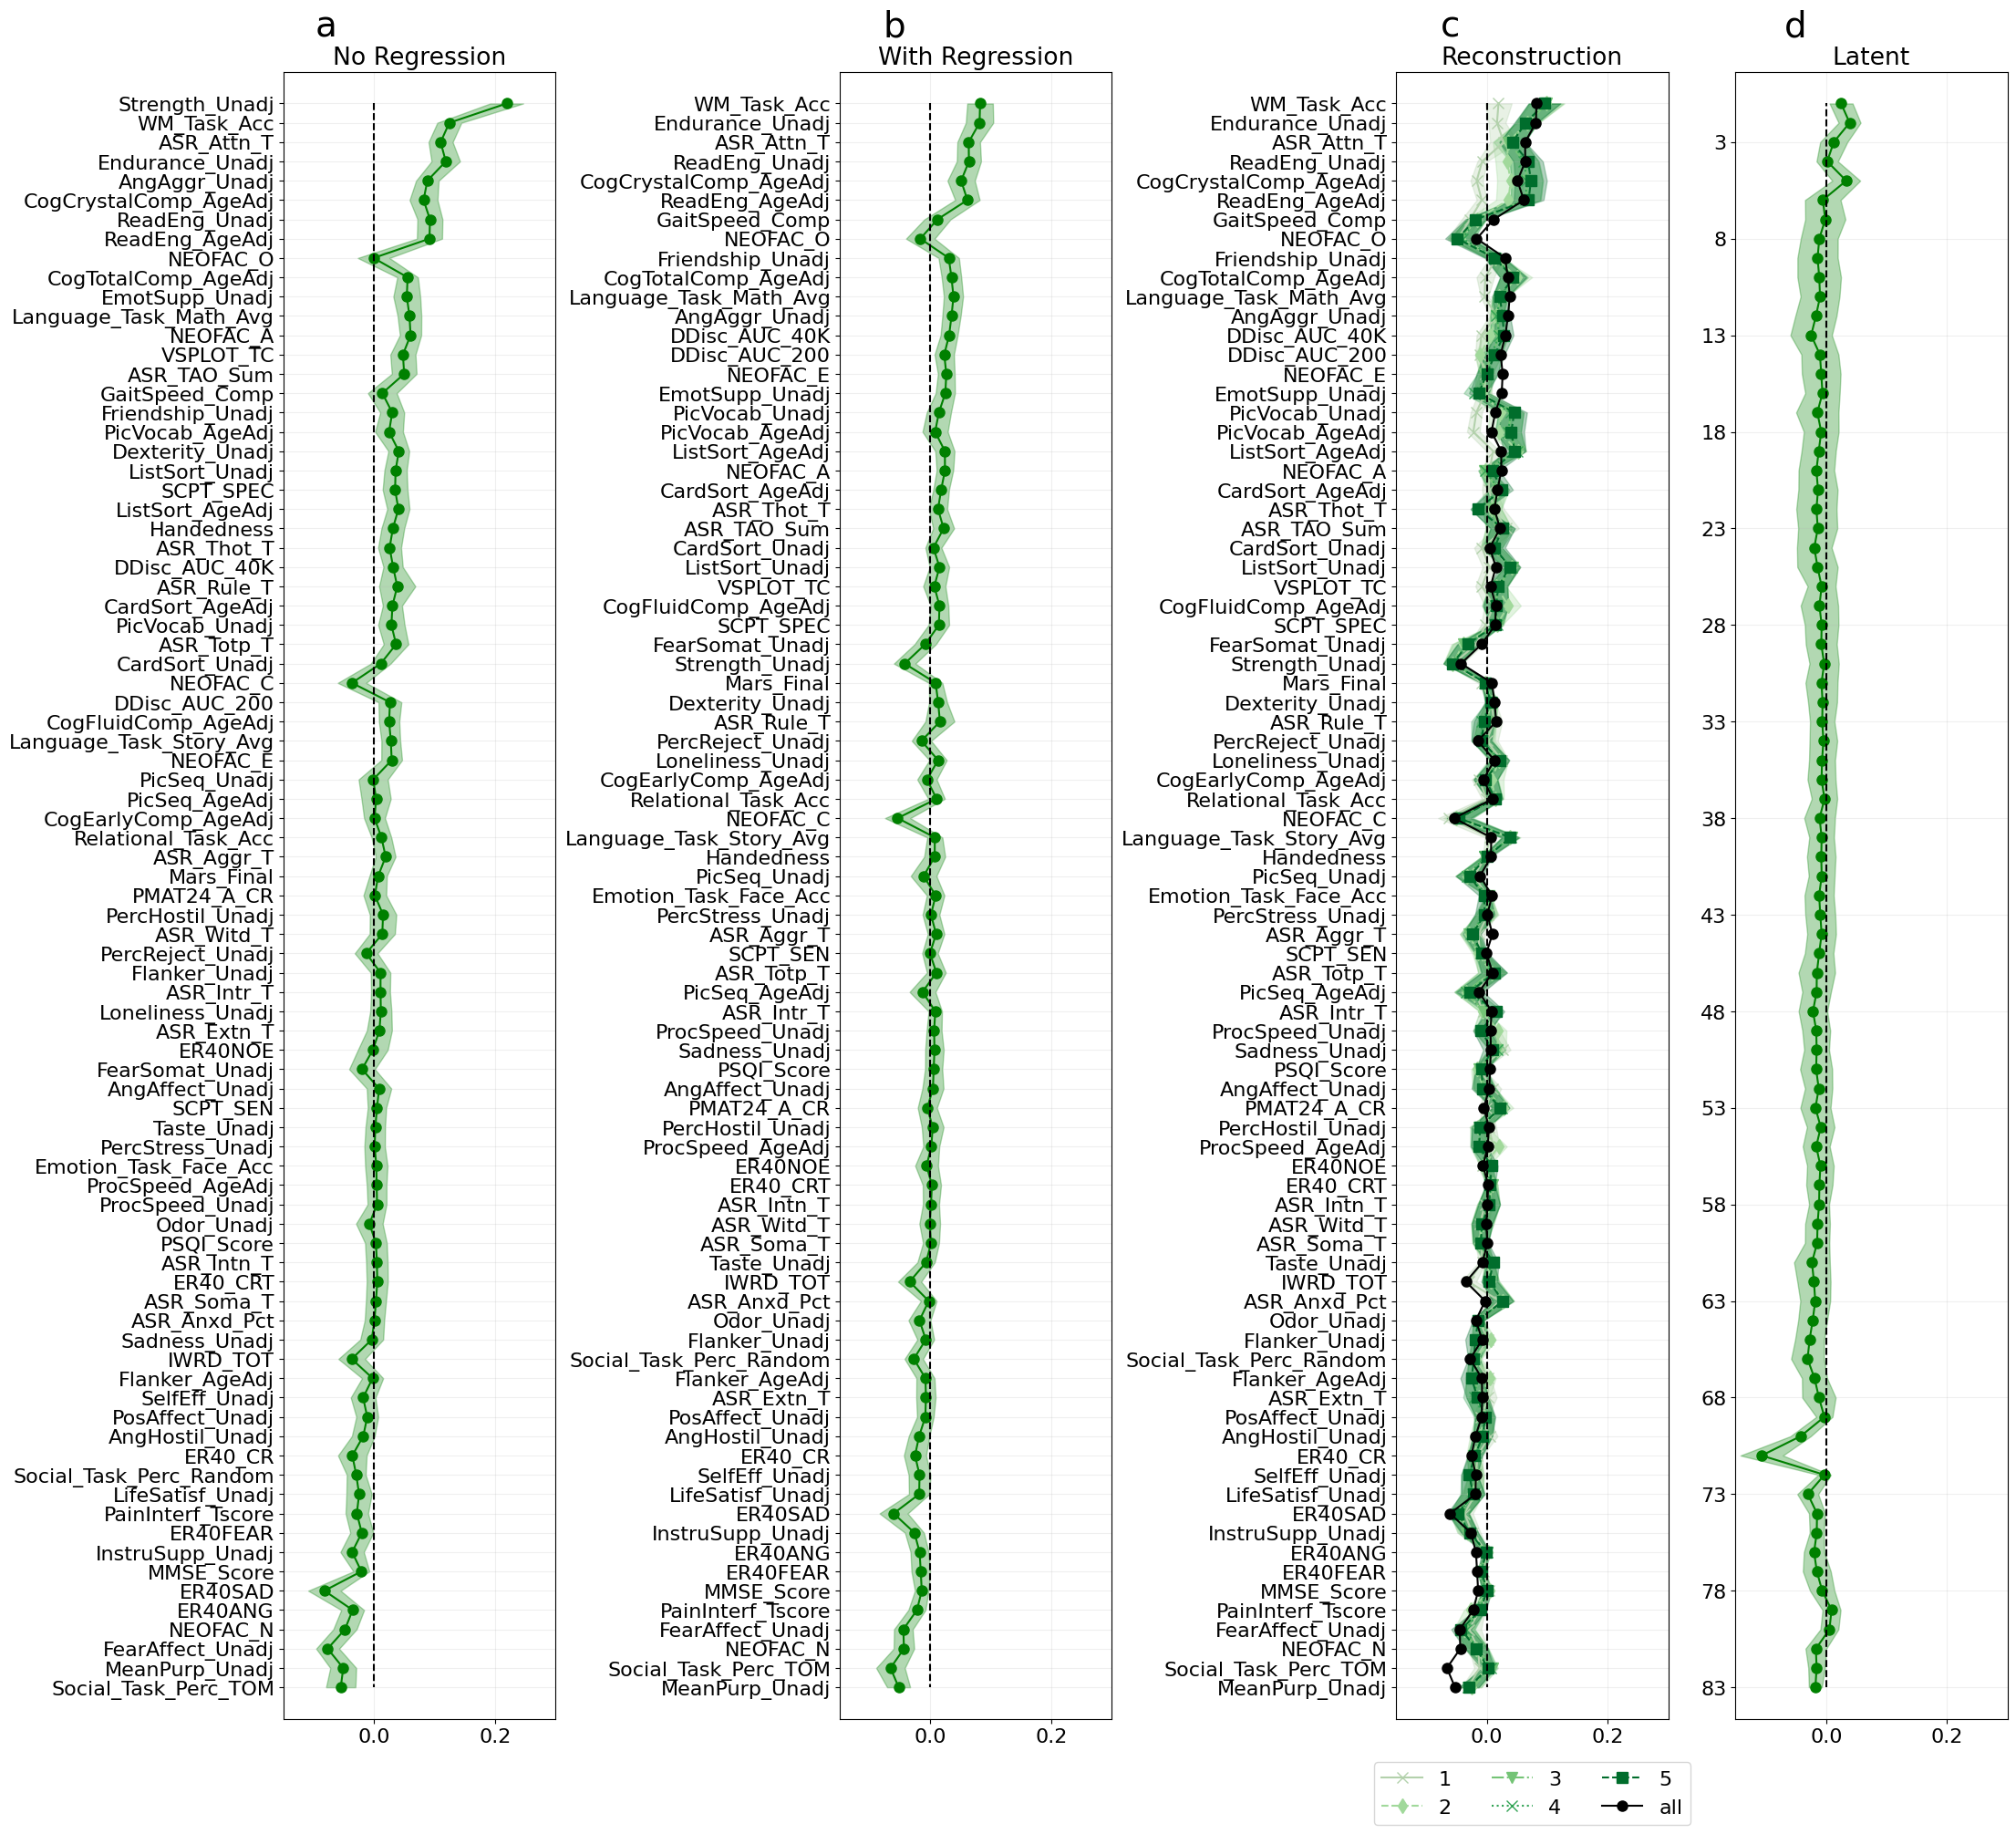

In [14]:
# general settings
# fig, ax = plt.subplots(1, 4, figsize=(22, 20), gridspec_kw={'wspace':.5})
#gridspec = dict(hspace=0.0, height_ratios=[1, 1, 0.4, 3])
fig, ax = plt.subplots(1, 4, figsize=(22, 20), gridspec_kw={'width_ratios':[2, 2, 2, 2]}, layout='constrained')

dataset = 'HCP'
y_val = 'orig'
file_dir = Path(f"/Users/jdafflon/Code/bblocks-phenotypes/outputs/{dataset}")
recons = [83]


###########################################################################################
# No Regression
###########################################################################################
folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
r2 = np.array(metrics_dic['R2'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']

# plot
ax[0].plot(np.mean(r2, axis=0)[arg_sort][::-1], sorted_targets_hcp[::-1],
    marker='o',
    markersize=8,
    color='green')
ax[0].fill_betweenx(sorted_targets_hcp[::-1],
                np.mean(r2, axis=0)[arg_sort][::-1] -
                np.std(r2, axis=0)[arg_sort][::-1],
                np.mean(r2, axis=0)[arg_sort][::-1] +
                np.std(r2, axis=0)[arg_sort][::-1],
                alpha=0.3,
                color='green')
ax[0].set_title('No Regression')
ax[0].grid(alpha=.2)

# add line at 0
ax[0].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')


###########################################################################################
# Regression
###########################################################################################
#folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets_regress_covariates"
folder_name = f'regress_covariates_predictions-{dataset.lower()}_test'

metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
r2 = np.array(metrics_dic['R2'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']

# plot
ax[1].plot(np.mean(r2, axis=0)[arg_sort][::-1], sorted_targets_hcp[::-1],
    marker='o',
    markersize=8,
    color='green')
ax[1].fill_betweenx(sorted_targets_hcp[::-1],
                np.mean(r2, axis=0)[arg_sort][::-1] -
                np.std(r2, axis=0)[arg_sort][::-1],
                np.mean(r2, axis=0)[arg_sort][::-1] +
                np.std(r2, axis=0)[arg_sort][::-1],
                alpha=0.3,
                color='green')
ax[1].set_title('With Regression')
ax[1].grid(alpha=.2)

# add line at 0
ax[1].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')


###########################################################################################
# Reconstuction
###########################################################################################
# general settings
markers = ['x', 'd', 'v', 'x', 's', 'o']
linestyle = ['-' , '--' , '-.' , ':', '--', '-']

# Dataset specific settings
recons = [1, 2, 3, 4, 5, 83]
colors=['#b3d1ac', '#a1d99b', '#74c476', '#31a354', '#006d2c', 'k']
alphas = np.arange(0.2, 1, 1/(len(recons) + 1))

df_corr_mean_hcp, df_corr_std_hcp, df_r2_mean_hcp, df_r2_std_hcp, sorted_targets_hcp = load_data_reconstruction(dataset, file_dir, y_val)

# plot
for idx, n_recons in enumerate(recons, 1):
    ax[2].plot(df_r2_mean_hcp[f'mean_{n_recons}'].iloc[::-1], sorted_targets_hcp[::-1],
        marker=markers[idx-1],
        linestyle=linestyle[idx-1],
        markersize=8,
        label='all' if n_recons == recons[-1] else n_recons,
        color=colors[idx-1])
    if n_recons != recons[-1]:
        ax[2].fill_betweenx(sorted_targets_hcp[::-1],
                    df_r2_mean_hcp[f'mean_{n_recons}'].iloc[::-1] -
                    df_r2_std_hcp[f'std_{n_recons}'].iloc[::-1],
                    df_r2_mean_hcp[f'mean_{n_recons}'].iloc[::-1] +
                    df_r2_std_hcp[f'std_{n_recons}'].iloc[::-1],
                    alpha=0.3,
                    color=colors[idx-1])
    ax[2].set_title('Reconstruction')
    ax[2].grid(alpha=.2)

# add line at 0
ax[2].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')
# add legends
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=3)

# Share axis
#ax[1].sharey(ax[0])
#ax[1].get_yaxis().set_visible(False)
#ax[2].set_yticklabels([])
#ax[2].set_yticks([])
###########################################################################################
# Latent 
###########################################################################################
folder_name = f"regress_covariates_predictions-{dataset.lower()}-latent_targets-zscore_column"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
r2 = np.array(metrics_dic['R2'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']

# plot
ax[3].plot(np.mean(r2, axis=0)[::-1], sorted_targets_hcp,
    marker='o',
    markersize=8,
    color='green')
ax[3].fill_betweenx(sorted_targets_hcp,
                np.mean(r2, axis=0)[::-1] -
                np.std(r2, axis=0)[::-1],
                np.mean(r2, axis=0)[::-1]+
                np.std(r2, axis=0)[::-1],
                alpha=0.3,
                color='green')
ax[3].set_title('Latent')
ax[3].grid(alpha=.2)
# fix the order that the latent variables are plotted
ax[3].set_yticks(sorted_targets_hcp[::5])
ax[3].set_yticklabels(range(83, 0, -5))

# add line at 0
ax[3].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')

#fig.subplots_adjust(wspace=0)
#fig.subplots_adjust(hspace=0)
ax[0].text(-.08, 85.5, 'a', fontsize=28, ha='center')
ax[1].text(-.06, 85.5, 'b', fontsize=28, ha='center')
ax[2].text(-.06, 85.5, 'c', fontsize=28, ha='center')
ax[3].text(-.05, 85.5, 'd', fontsize=28, ha='center')

# set xlim of all plots to be the same
ax[0].set_xlim([-0.15, .3])
ax[1].set_xlim([-0.15, .3])
ax[2].set_xlim([-0.15, .3])
ax[3].set_xlim([-0.15, .3])


#plt.tight_layout()
plt.savefig(output_dir / 'all_hcp_r2.pdf')
plt.show()



# PNC (correlation)

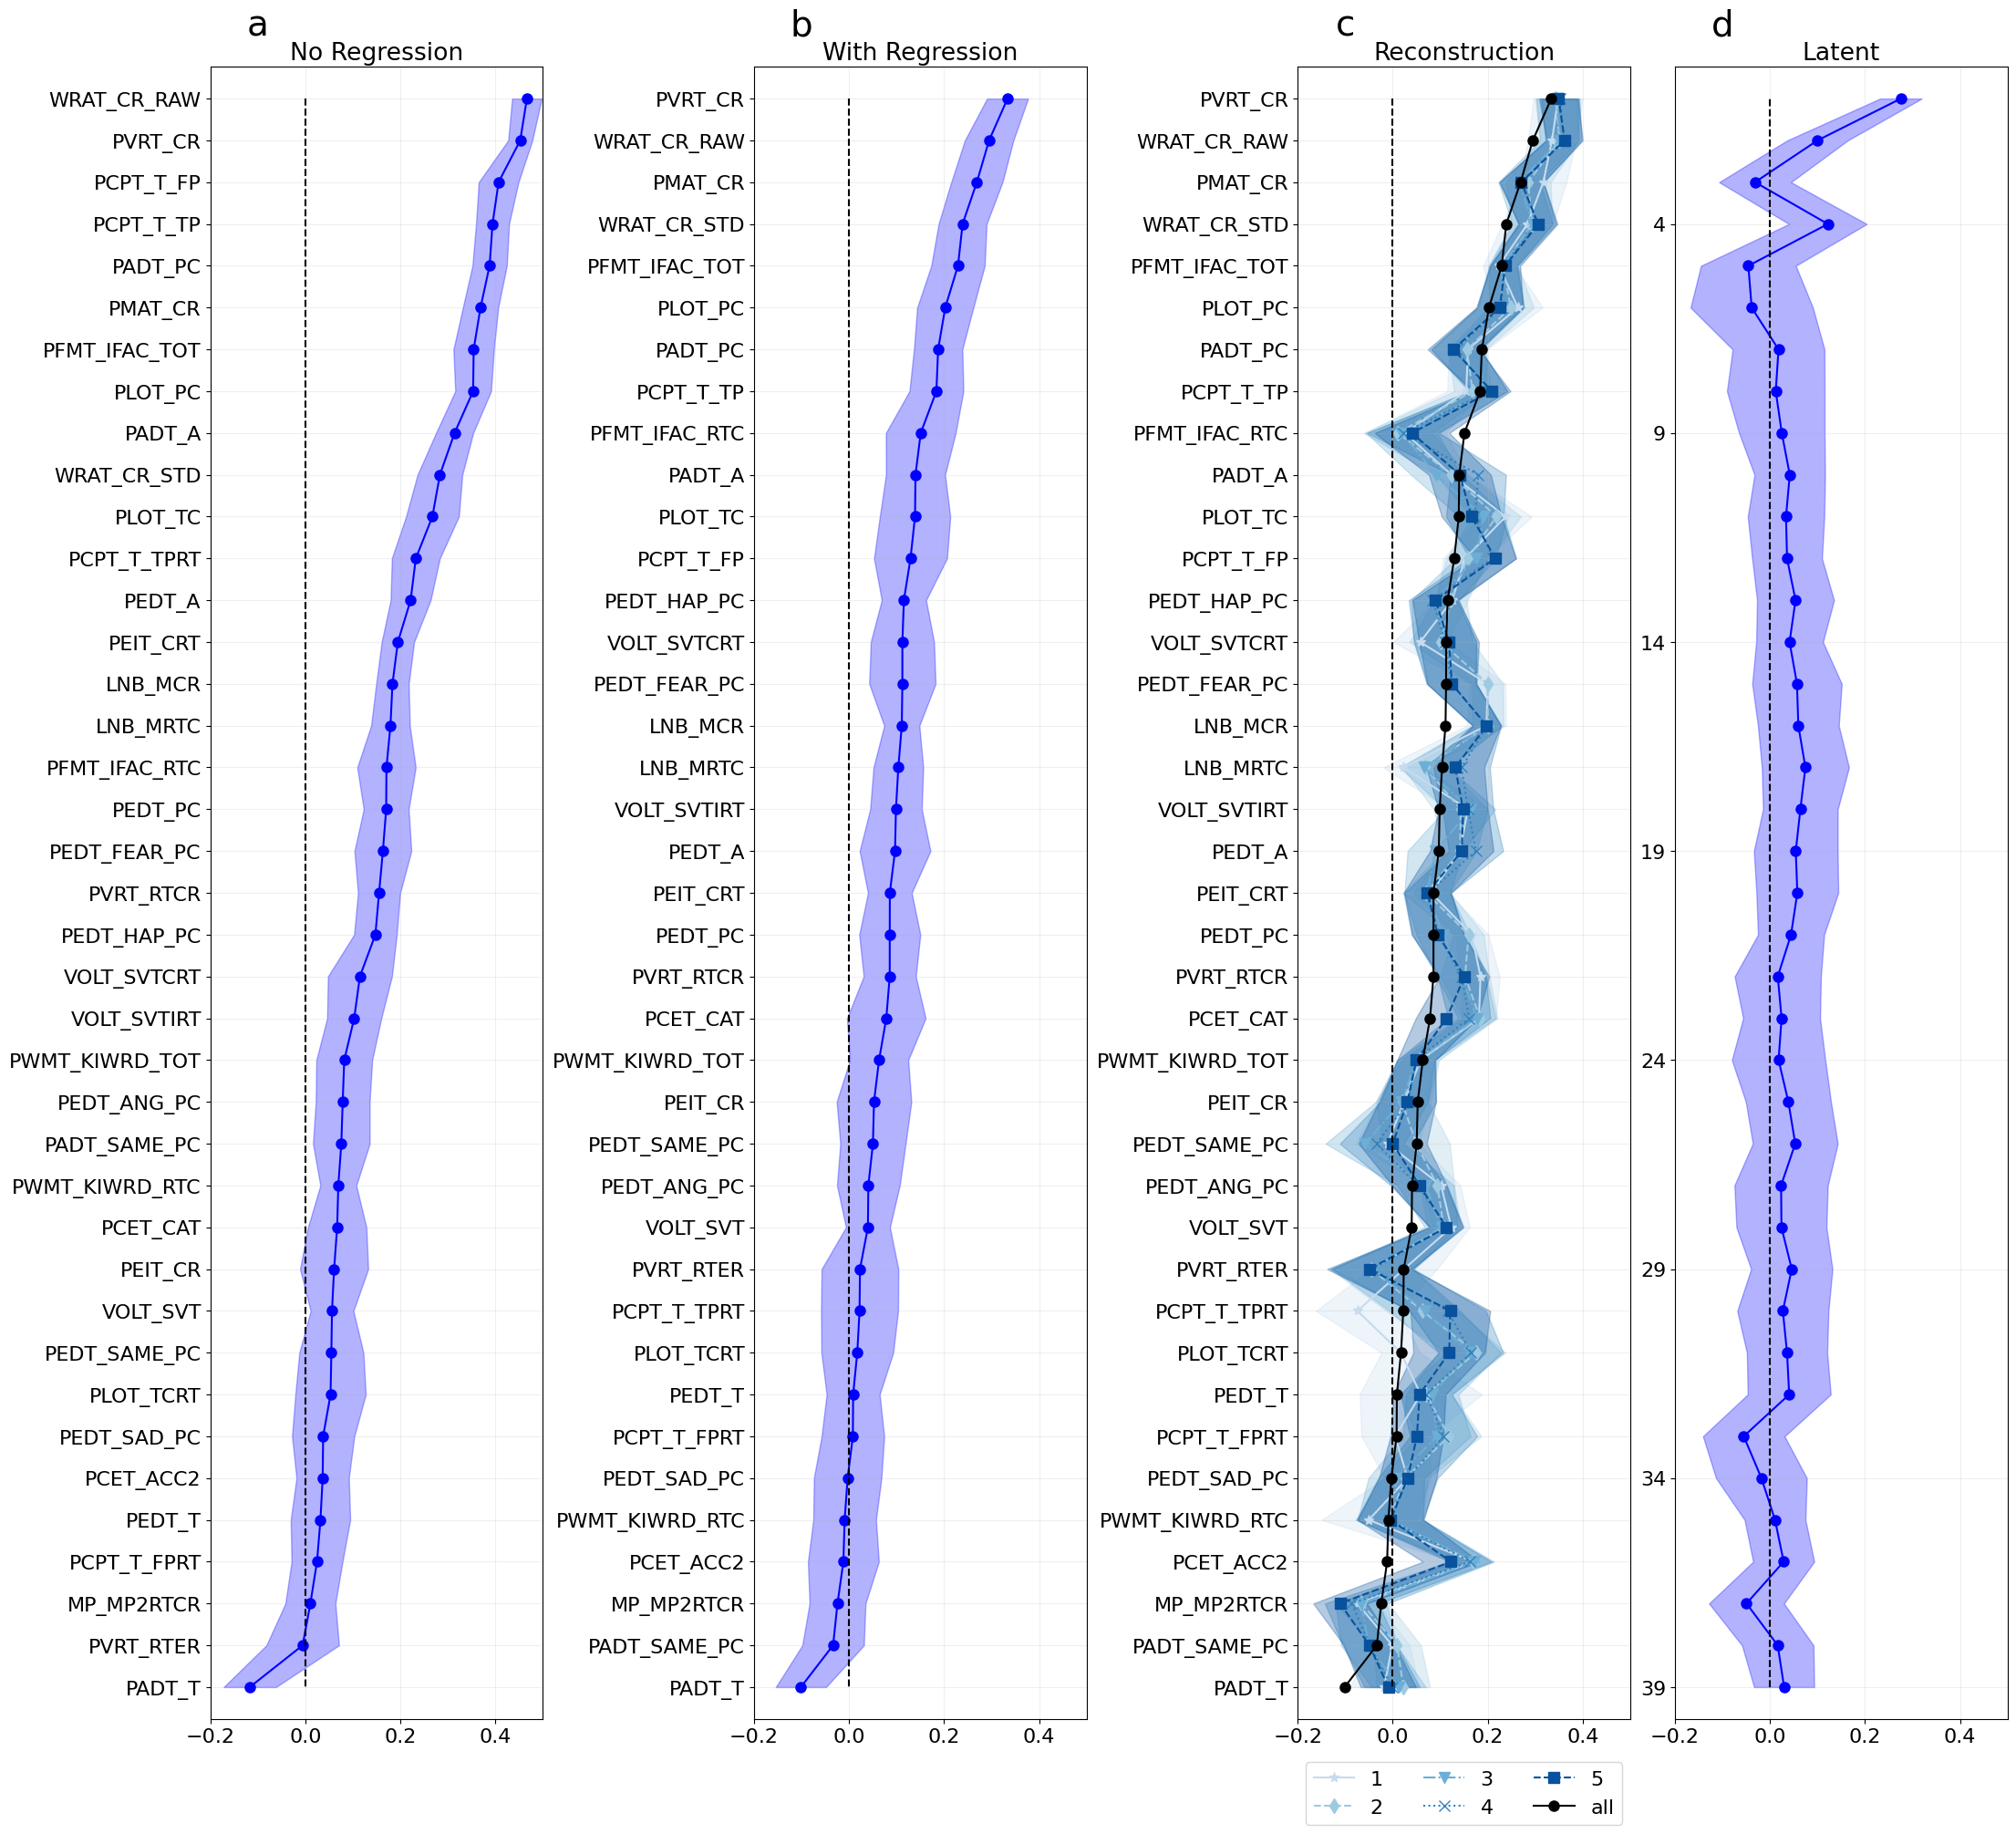

In [18]:
# general settings
# fig, ax = plt.subplots(1, 4, figsize=(22, 20), gridspec_kw={'wspace':.5})
#gridspec = dict(hspace=0.0, height_ratios=[1, 1, 0.4, 3])
fig, ax = plt.subplots(1, 4, figsize=(22, 20), gridspec_kw={'width_ratios':[2, 2, 2, 2]}, layout='constrained')

dataset = 'PNC'
y_val = 'orig'
file_dir = project_dir / 'outputs' / dataset
recons = [39]


###########################################################################################
# No Regression
###########################################################################################
folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
r2 = np.array(metrics_dic['R2'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']

# plot
ax[0].plot(np.mean(corr, axis=0)[arg_sort][::-1], sorted_targets_hcp[::-1],
    marker='o',
    markersize=8,
    color='blue')
ax[0].fill_betweenx(sorted_targets_hcp[::-1],
                np.mean(corr, axis=0)[arg_sort][::-1] -
                np.std(corr, axis=0)[arg_sort][::-1],
                np.mean(corr, axis=0)[arg_sort][::-1] +
                np.std(corr, axis=0)[arg_sort][::-1],
                alpha=0.3,
                color='blue')
ax[0].set_title('No Regression')
ax[0].grid(alpha=.2)

# add line at 0
ax[0].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')


###########################################################################################
# Regression
###########################################################################################
#folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets_regress_covariates"
folder_name = f'regress_covariates_predictions-{dataset.lower()}_test'

metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
r2 = np.array(metrics_dic['R2'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']
# save the corr variable to perform statistic analysis
corr_regression = corr

# plot
ax[1].plot(np.mean(corr, axis=0)[arg_sort][::-1], sorted_targets_hcp[::-1],
    marker='o',
    markersize=8,
    color='blue')
ax[1].fill_betweenx(sorted_targets_hcp[::-1],
                np.mean(corr, axis=0)[arg_sort][::-1] -
                np.std(corr, axis=0)[arg_sort][::-1],
                np.mean(corr, axis=0)[arg_sort][::-1] +
                np.std(corr, axis=0)[arg_sort][::-1],
                alpha=0.3,
                color='blue')
ax[1].set_title('With Regression')
ax[1].grid(alpha=.2)

# add line at 0
ax[1].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')


###########################################################################################
# Reconstuction
###########################################################################################
# general settings
markers = ['*', 'd', 'v', 'x', 's', 'o']
linestyle = ['-' , '--' , '-.' , ':', '--', '-']

# Dataset specific settings
recons =  [1, 2, 3, 4, 5, 39]
colors=['#c6dbef', '#9ecae1', '#6baed6', '#3182bd', '#08519c', 'k']
alphas = np.arange(0.2, 1, 1/(len(recons) + 1))

df_corr_mean_hcp, df_corr_std_hcp, df_r2_mean_hcp, df_r2_std_hcp, sorted_targets_hcp = load_data_reconstruction(dataset, file_dir, y_val)

# plot
for idx, n_recons in enumerate(recons, 1):
    ax[2].plot(df_corr_mean_hcp[f'mean_{n_recons}'].iloc[::-1], sorted_targets_hcp[::-1],
        marker=markers[idx-1],
        linestyle=linestyle[idx-1],
        markersize=8,
        label='all' if n_recons == recons[-1] else n_recons,
        color=colors[idx-1])
    if n_recons != recons[-1]:
        ax[2].fill_betweenx(sorted_targets_hcp[::-1],
                    df_corr_mean_hcp[f'mean_{n_recons}'].iloc[::-1] -
                    df_corr_std_hcp[f'std_{n_recons}'].iloc[::-1],
                    df_corr_mean_hcp[f'mean_{n_recons}'].iloc[::-1] +
                    df_corr_std_hcp[f'std_{n_recons}'].iloc[::-1],
                    alpha=0.3,
                    color=colors[idx-1])
    ax[2].set_title('Reconstruction')
    ax[2].grid(alpha=.2)

# add line at 0
ax[2].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')
# add legends
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=3)

# Share axis
#ax[1].sharey(ax[0])
#ax[1].get_yaxis().set_visible(False)
#ax[2].set_yticklabels([])
#ax[2].set_yticks([])
###########################################################################################
# Latent 
###########################################################################################
folder_name = f"regress_covariates_predictions-{dataset.lower()}-latent_targets-zscore_column"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
r2 = np.array(metrics_dic['R2'])
sorted_targets_hcp = metrics['sorted_targets']

# plot
ax[3].plot(np.mean(corr, axis=0)[::-1], sorted_targets_hcp,
    marker='o',
    markersize=8,
    color='blue')
ax[3].fill_betweenx(sorted_targets_hcp,
                np.mean(corr, axis=0)[::-1] -
                np.std(corr, axis=0)[::-1],
                np.mean(corr, axis=0)[::-1]+
                np.std(corr, axis=0)[::-1],
                alpha=0.3,
                color='blue')
ax[3].set_title('Latent')
ax[3].grid(alpha=.2)
# fix the order that the latent variables are plotted
ax[3].set_yticks(sorted_targets_hcp[::5])
ax[3].set_yticklabels(range(39, 0, -5))

# add line at 0
ax[3].vlines(0, sorted_targets_hcp[0], sorted_targets_hcp[-1], colors='black', linestyle='dashed')

#fig.subplots_adjust(wspace=0)
#fig.subplots_adjust(hspace=0)

# Add text labels
ax[0].text(-.1, 39.5, 'a', fontsize=28, ha='center')
ax[1].text(-.1, 39.5, 'b', fontsize=28, ha='center')
ax[2].text(-.1, 39.5, 'c', fontsize=28, ha='center')
ax[3].text(-.1, 39.5, 'd', fontsize=28, ha='center')

# set xlim of all plots to be the same
ax[0].set_xlim([-0.2, .5])
ax[1].set_xlim([-0.2, .5])
ax[2].set_xlim([-0.2, .5])
ax[3].set_xlim([-0.2, .5])

#plt.tight_layout()
plt.savefig(output_dir / 'all_pnc.pdf')
plt.show()


In [ ]:
# Check if there is a statistic difference between the phenotype with the largest prediction and the
# most predictable latent factor 

highest_latent = corr[:, 0] # first latent factor
highest_phenotype = corr_regression[:, arg_sort][:, 0] # first phenotype
res = ttest_rel(highest_latent, highest_phenotype)
print(f"t-testic: {res[0]:.3f}, p-value: {res[1]:.3f}")
print(res)

In [ ]:
highest_latent

In [ ]:
corr_regression[:, arg_sort][:, 0]

In [ ]:
print(np.mean(highest_latent), np.mean(highest_phenotype))

In [ ]:
print(f'{np.mean(highest_latent):.2f} \pm {np.std(highest_latent):3f}'),
print(f'{np.mean(highest_phenotype):.2f} \pm {np.std(highest_phenotype):.3f}')


In [ ]:
# PNC (R2)

In [22]:
# general settings
# fig, ax = plt.subplots(1, 4, figsize=(22, 20), gridspec_kw={'wspace':.5})
#gridspec = dict(hspace=0.0, height_ratios=[1, 1, 0.4, 3])
fig, ax = plt.subplots(1, 4, figsize=(22, 20), gridspec_kw={'width_ratios':[2, 2, 2, 2]}, layout='constrained')

dataset = 'PNC'
y_val = 'orig'
file_dir = project_dir / 'outputs' / dataset
recons = [39]

###########################################################################################
# No Regression
###########################################################################################
folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
r2 = np.array(metrics_dic['R2'])
sorted_targets_pnc = metrics['sorted_targets']
arg_sort = metrics['arg_sort']

# plot
ax[0].plot(np.mean(r2, axis=0)[arg_sort][::-1], sorted_targets_pnc[::-1],
    marker='o',
    markersize=8,
    color='blue')
ax[0].fill_betweenx(sorted_targets_pnc[::-1],
                np.mean(r2, axis=0)[arg_sort][::-1] -
                np.std(r2, axis=0)[arg_sort][::-1],
                np.mean(r2, axis=0)[arg_sort][::-1] +
                np.std(r2, axis=0)[arg_sort][::-1],
                alpha=0.3,
                color='blue')
ax[0].set_title('No Regression')
ax[0].grid(alpha=.2)

# add line at 0
ax[0].vlines(0, sorted_targets_pnc[0], sorted_targets_pnc[-1], colors='black', linestyle='dashed')


###########################################################################################
# Regression
###########################################################################################
#folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets_regress_covariates"
folder_name = f'regress_covariates_predictions-{dataset.lower()}_test'

metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
r2 = np.array(metrics_dic['R2'])
sorted_targets_hcp = metrics['sorted_targets']
arg_sort = metrics['arg_sort']

# plot
ax[1].plot(np.mean(r2, axis=0)[arg_sort][::-1], sorted_targets_hcp[::-1],
    marker='o',
    markersize=8,
    color='blue')
ax[1].fill_betweenx(sorted_targets_hcp[::-1],
                np.mean(r2, axis=0)[arg_sort][::-1] -
                np.std(r2, axis=0)[arg_sort][::-1],
                np.mean(r2, axis=0)[arg_sort][::-1] +
                np.std(r2, axis=0)[arg_sort][::-1],
                alpha=0.3,
                color='blue')
ax[1].set_title('With Regression')
ax[1].grid(alpha=.2)

# add line at 0
ax[1].vlines(0, sorted_targets_pnc[0], sorted_targets_pnc[-1], colors='black', linestyle='dashed')


###########################################################################################
# Reconstuction
###########################################################################################
# general settings
markers = ['*', 'd', 'v', 'x', 's', 'o']
linestyle = ['-' , '--' , '-.' , ':', '--', '-']

# Dataset specific settings
recons =  [1, 2, 3, 4, 5, 39]
colors=['#c6dbef', '#9ecae1', '#6baed6', '#3182bd', '#08519c', 'k']
alphas = np.arange(0.2, 1, 1/(len(recons) + 1))

df_corr_mean, df_corr_std, df_r2_mean, df_r2_std, sorted_targets_pnc = load_data_reconstruction(dataset, file_dir, y_val)

# plot
for idx, n_recons in enumerate(recons, 1):
    ax[2].plot(df_r2_mean[f'mean_{n_recons}'].iloc[::-1], sorted_targets_pnc[::-1],
        marker=markers[idx-1],
        linestyle=linestyle[idx-1],
        markersize=8,
        label='all' if n_recons == recons[-1] else n_recons,
        color=colors[idx-1])
    if n_recons != recons[-1]:
        ax[2].fill_betweenx(sorted_targets_pnc[::-1],
                    df_r2_mean[f'mean_{n_recons}'].iloc[::-1] -
                    df_r2_std[f'std_{n_recons}'].iloc[::-1],
                    df_r2_mean[f'mean_{n_recons}'].iloc[::-1] +
                    df_r2_std[f'std_{n_recons}'].iloc[::-1],
                    alpha=0.3,
                    color=colors[idx-1])
    ax[2].set_title('Reconstruction')
    ax[2].grid(alpha=.2)

# add line at 0
ax[2].vlines(0, sorted_targets_pnc[0], sorted_targets_pnc[-1], colors='black', linestyle='dashed')
# add legends
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=3)

# Share axis
#ax[1].sharey(ax[0])
#ax[1].get_yaxis().set_visible(False)
#ax[2].set_yticklabels([])
#ax[2].set_yticks([])
###########################################################################################
# Latent 
###########################################################################################
folder_name = f"regress_covariates_predictions-{dataset.lower()}-latent_targets-zscore_column"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
r2 = np.array(metrics_dic['R2'])
sorted_targets_pnc = metrics['sorted_targets']
arg_sort = metrics['arg_sort']

# plot
ax[3].plot(np.mean(r2, axis=0)[::-1], sorted_targets_pnc,
    marker='o',
    markersize=8,
    color='blue')
ax[3].fill_betweenx(sorted_targets_pnc,
                np.mean(r2, axis=0)[::-1] -
                np.std(r2, axis=0)[::-1],
                np.mean(r2, axis=0)[::-1]+
                np.std(r2, axis=0)[::-1],
                alpha=0.3,
                color='blue')
ax[3].set_title('Latent')
ax[3].grid(alpha=.2)
# fix the order that the latent variables are plotted
ax[3].set_yticks(sorted_targets_pnc[::5])
ax[3].set_yticklabels(range(39, 0, -5))

# add line at 0
ax[3].vlines(0, sorted_targets_pnc[0], sorted_targets_pnc[-1], colors='black', linestyle='dashed')

#fig.subplots_adjust(wspace=0)
#fig.subplots_adjust(hspace=0)

# Add text labels
ax[0].text(-.06, 39.5, 'a', fontsize=28, ha='center')
ax[1].text(-.04, 39.5, 'b', fontsize=28, ha='center')
ax[2].text(-.05, 39.5, 'c', fontsize=28, ha='center')
ax[3].text(-.04, 39.5, 'd', fontsize=28, ha='center')

# set xlim of all plots to be the same
ax[0].set_xlim([-0.15, .2])
ax[1].set_xlim([-0.15, .2])
ax[2].set_xlim([-0.15, .2])
ax[3].set_xlim([-0.15, .2])

#plt.tight_layout()
plt.savefig(output_dir / 'all_pnc_r2.pdf')

plt.show()

In [ ]:
###########################################################################################
# Regression - Check values for the text
###########################################################################################
dataset = 'PNC'
file_dir = Path(f"/Users/jdafflon/Code/bblocks-phenotypes/outputs/{dataset}")

folder_name = f"no_regress_covariates_predictions-{dataset.lower()}_raw_targets_regress_covariates"
metrics = np.load(file_dir / folder_name / 'metrics.npz', allow_pickle=True)
arg_sort = metrics['arg_sort']
with open(file_dir / folder_name / 'metrics.pickle', 'rb') as handle:
    metrics_dic = pickle.load(handle)
  
corr = np.array(metrics_dic['Correlation'])
df_corr = pd.DataFrame(corr)
# reorder columns based on their performance
df_corr = df_corr[arg_sort]
df_corr = df_corr.rename(columns={sorted: metrics['sorted_targets'][i] for i, sorted in enumerate(arg_sort)})
df_corr.describe().round(3) # round up to 3 values precision



In [ ]:
# do the same with r2
r2 = np.array(metrics_dic['R2'])
df_r2 = pd.DataFrame(r2)
df_r2 = df_r2[arg_sort]
df_r2 = df_r2.rename(columns={sorted: metrics['sorted_targets'][i] for i, sorted in enumerate(arg_sort)})
df_r2.describe().round(3) # round up to 3 values precision